In [24]:
%run preprocessing.ipynb

# Plot with sklearn
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

Number of unique encounters: 101766
Number of columns: 53
Number of unique encounters after only keeping first encounter for each patient and filtering by admission_type : 60571


In [211]:
import seaborn as sns
import matplotlib.pyplot as plt

def calculate_tpr_fpr(y_real, y_pred):
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    
    return tpr, fpr

def get_n_roc_coordinates(y_real, y_proba, n = 100):
    tpr_list = [0]
    fpr_list = [0]
    for i in range(n):
        threshold = i/n
        y_pred = y_proba[:, 1] > threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

def plot_roc_curve(tpr, fpr, ax, group, scatter = False):
    if scatter:
        sns.scatterplot(x = fpr, y = tpr)
    sns.lineplot(x = fpr, y = tpr, ax=ax,label=group)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'black', ax=ax, linestyle='--')
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

In [209]:
def roc_curve_protected(X_train, y_train, X_test, y_test, group_train, group_test, PROTECTED_FEATURES):
    # debias data
    X_train_decorrelated = correlation_remover(X_train, group_train, lambda_=0)
    X_test_decorrelated = correlation_remover(X_test, group_test, lambda_=0)

    # get probas for baseline model
    base_preds, base_probas, _ = fit_logistic_regression(X_train, y_train, X_test)
    
    # get probas for debiased data 
    debiased_preds, debiased_probas, _ = fit_logistic_regression(X_train_decorrelated, y_train, X_test_decorrelated)
    
    # compile df for plotting
    plot_data = pd.from_dummies(group_test,sep='_')
    plot_data["baseline_proba"] = base_probas[:, 1]
    plot_data["debiased_proba"] = debiased_probas[:, 1]
    plot_data["true"] = y_test

    # plot for each protected feature before and after debiasing
    _, axes = plt.subplots(2, len(PROTECTED_FEATURES),figsize=(15, 10))
    _.suptitle("ROC curves for baseline and debiased models",fontsize=15)
    
    tpr_rmse = {}

    for i, feature in enumerate(PROTECTED_FEATURES):
        tpr_rmse[feature] = {}

        for category in np.unique(plot_data[feature]):
            tpr_rmse[feature][category] = {}
            cat_true, cat_proba_preds_baseline = plot_data[plot_data[feature]==category][["true", "baseline_proba"]].to_numpy().T
            fpr_base, tpr_base, _ = roc_curve(cat_true, cat_proba_preds_baseline)
            
            
            # calculate rmse for each all tpr for each category

            tpr_rmse[feature][category]["baseline"] = np.sqrt(np.mean(tpr_base**2))
            roc_display = RocCurveDisplay(fpr=fpr_base, tpr=tpr_base)
            roc_display.plot(ax=axes[0, i], name=f"{category}")
            
            # for category in np.unique(plot_data[feature]):
            cat_true, cat_proba_preds_debiased = plot_data[plot_data[feature]==category][["true", "debiased_proba"]].to_numpy().T
            fpr_debiased, tpr_debiased, _ = roc_curve(cat_true, cat_proba_preds_debiased)
            tpr_rmse[feature][category]["debiased"] = np.sqrt(np.mean(tpr_debiased**2))
            roc_display = RocCurveDisplay(fpr=fpr_debiased, tpr=tpr_debiased)
            roc_display.plot(ax=axes[1, i], name=f"{category}",)

        axes[0, i].set_title(f"{feature} (baseline)",fontsize=15)
        axes[0, i].plot([0, 1], [0, 1], color = 'black', linestyle = '--')
        axes[1, i].set_title(f"{feature} (debiased)",fontsize=15)
        axes[1, i].plot([0, 1], [0, 1], color = 'black', linestyle = '--')


        print(tpr_rmse[feature][category]["baseline"], tpr_rmse[feature][category]["debiased"])
    return _, axes

0.6214129070261832 0.6259318996706763
0.6221127435159606 0.6104733067902844
0.617406874310078 0.6238347187171224


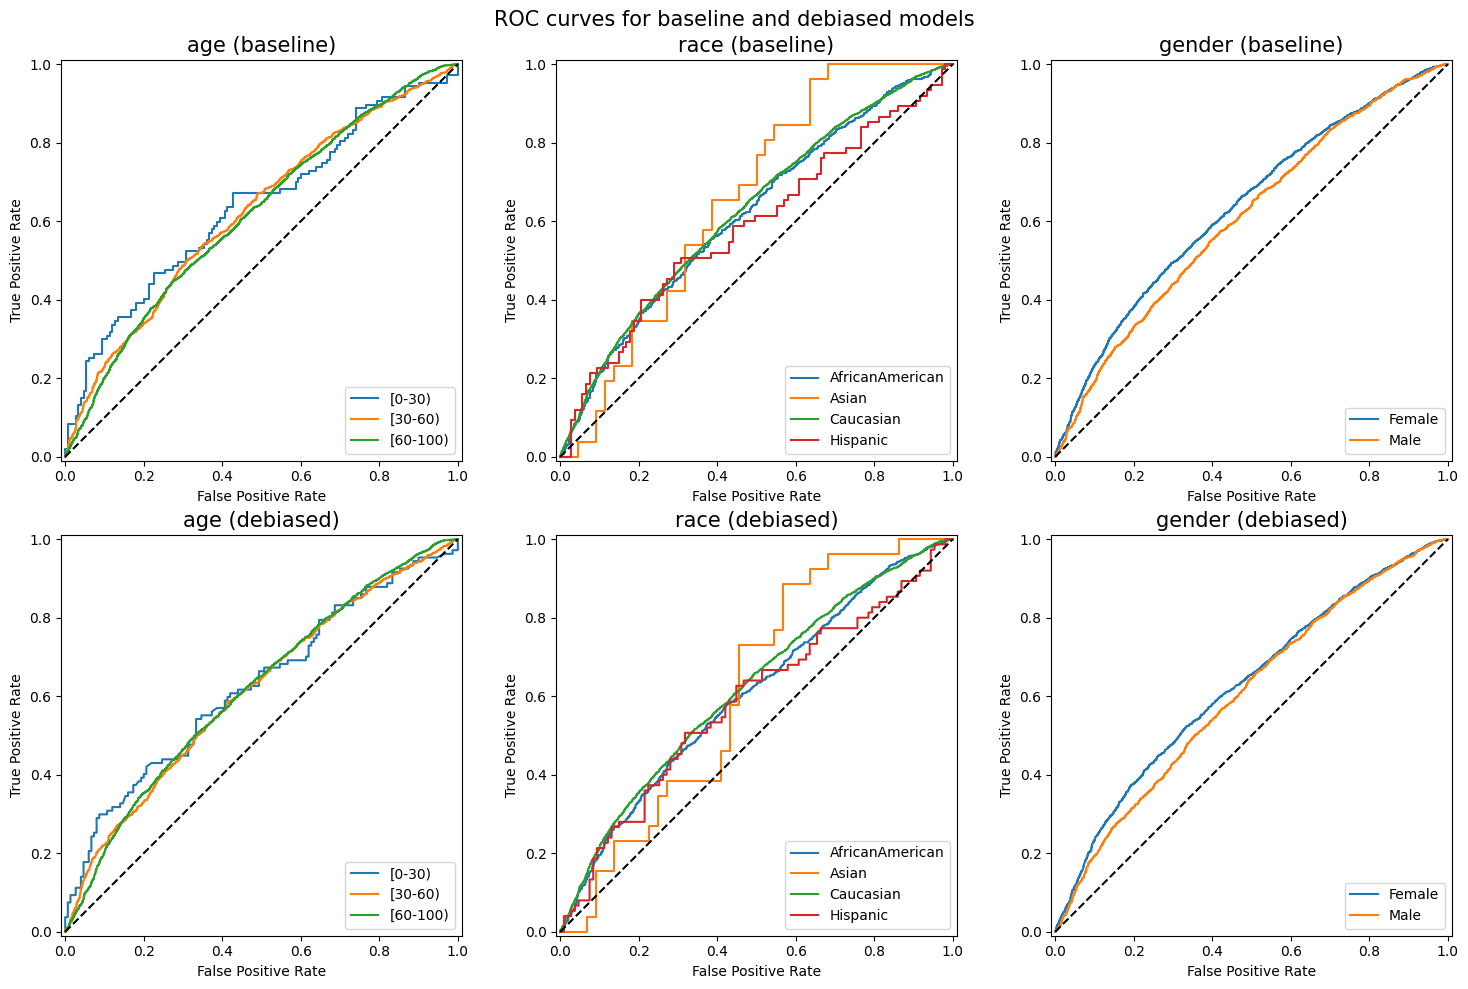

In [210]:
fig, ax = roc_curve_protected(X_train, y_train, X_test, y_test, group_train, group_test, PROTECTED_FEATURES)
plt.tight_layout()
plt.show()